# ML Classification Project - Land Cover Classification

In [2]:
# Import necessary modules
# ************************

import ee
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

print("success!!")

success!!


In [3]:
# Authenticate the project
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize(project='project-id')

In [4]:
# Define our classification scheme
LAND_COVER_CLASSES = {
    1: 'Water',
    2: 'Urban',
    3: 'Forest',
    4: 'Agriculture',
    5: 'Grassland',
    6: 'Barren'
}

print("Our Classification Scheme:")
for code, name in LAND_COVER_CLASSES.items():
    print(f"  {code}: {name}")

Our Classification Scheme:
  1: Water
  2: Urban
  3: Forest
  4: Agriculture
  5: Grassland
  6: Barren


In [5]:
# Define study area - Mediterranean coastal region (example: Valencia, Spain region)
# You can modify these coordinates for your preferred study area
study_area = ee.Geometry.Rectangle([-0.5, 39.2, 0.2, 39.8])

# Visualize the study area
def create_study_area_map():
    """Create a simple visualization of our study area"""
    # Get a recent Sentinel-2 image for visualization
    s2_viz = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(study_area)
              .filterDate('2023-06-01', '2023-09-30')
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .median())

    # True color visualization parameters
    viz_params = {
        'min': 0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2']
    }

    return s2_viz, viz_params

base_image, viz_params = create_study_area_map()
print("Study area defined and base image prepared")

# Get basic information about our study area
area_info = study_area.area().divide(1000000).getInfo()  # Convert to km²
print(f"Study area: approximately {area_info:.1f} km²")

Study area defined and base image prepared
Study area: approximately 4007.0 km²


In [6]:
def create_feature_collection(image_collection, study_region):
    """
    Extract comprehensive features from Sentinel-2 imagery

    Think about this step: Why are we creating features rather than
    using raw spectral bands directly?
    """

    def add_spectral_indices(image):
        """Add spectral indices that highlight different land cover properties"""

        # Vegetation indices
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }
        ).rename('EVI')

        # Red-edge indices (unique to Sentinel-2)
        rendvi = image.normalizedDifference(['B8', 'B5']).rename('RENDVI')

        # Water indices
        ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
        mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')

        # Built-up indices
        ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')

        # Soil indices
        ndsi = image.normalizedDifference(['B11', 'B12']).rename('NDSI')

        return image.addBands([ndvi, evi, rendvi, ndwi, mndwi, ndbi, ndsi])

    # Apply feature extraction to collection
    featured_collection = image_collection.map(add_spectral_indices)

    return featured_collection

In [7]:
# Load and prepare Sentinel-2 data
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterBounds(study_area)
                 .filterDate('2023-06-01', '2023-09-30')  # Summer period
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 15)))

print(f"Found {s2_collection.size().getInfo()} Sentinel-2 images")

Found 56 Sentinel-2 images


In [8]:
# Apply cloud masking
def mask_s2_clouds(image):
    """Simple cloud masking using SCL band"""
    scl = image.select('SCL')
    # Keep vegetation, not-vegetated, water, unclassified (remove clouds, shadows, etc.)
    clear_mask = scl.lt(8).And(scl.neq(3)).And(scl.neq(2)).And(scl.neq(1)).And(scl.neq(0))
    return image.updateMask(clear_mask)

s2_cleaned = s2_collection.map(mask_s2_clouds)
print(f"After cloud masking: {s2_cleaned.size().getInfo()} images")

After cloud masking: 56 images


In [9]:
# Create feature-rich collection
s2_featured = create_feature_collection(s2_cleaned, study_area)

# Create median composite for training
median_composite = s2_featured.median()

## Training

In [10]:
# Define our feature set for classification
SPECTRAL_BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
DERIVED_FEATURES = ['NDVI', 'EVI', 'RENDVI', 'NDWI', 'MNDWI', 'NDBI', 'NDSI']

ALL_FEATURES = SPECTRAL_BANDS + DERIVED_FEATURES
print(f"Total features available: {len(ALL_FEATURES)}")
print("Features:", ALL_FEATURES)

# Select features for our composite
training_composite = median_composite.select(ALL_FEATURES)

Total features available: 17
Features: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'EVI', 'RENDVI', 'NDWI', 'MNDWI', 'NDBI', 'NDSI']


In [11]:
def create_training_data_strategy():
    """
    Design a robust training data collection approach

    Think about: What makes training data 'good' vs 'bad'?
    """

    # Define sampling points for each class
    # In practice, you might digitize these interactively or use existing reference data
    training_points = {
        'water': [
            [-0.1, 39.5], [-0.3, 39.4], [0.0, 39.6]
        ],
        'urban': [
            [-0.4, 39.4], [-0.1, 39.3], [0.1, 39.5]
        ],
        'forest': [
            [-0.2, 39.7], [0.0, 39.8], [-0.1, 39.7]
        ],
        'agriculture': [
            [-0.3, 39.6], [0.1, 39.4], [-0.2, 39.3]
        ],
        'grassland': [
            [0.0, 39.4], [-0.1, 39.6], [0.1, 39.7]
        ],
        'barren': [
            [-0.4, 39.3], [0.1, 39.3], [-0.2, 39.5]
        ]
    }

    return training_points

# For this exercise, we'll use a systematic sampling approach
def generate_training_samples(image, region, samples_per_class=50):
    """
    Generate training samples using a stratified random approach

    Discussion: What are the pros and cons of this automated approach
    versus manual digitization?
    """

    training_data = ee.FeatureCollection([])

    # This is a simplified approach - in practice, you'd want more sophisticated methods
    # For each class, we'll create sample points and assign labels

    class_samples = []
    for class_code, class_name in LAND_COVER_CLASSES.items():
        # Create random points within region
        points = ee.FeatureCollection.randomPoints(region, samples_per_class, seed=42+class_code)

        # Add class label
        labeled_points = points.map(lambda feat: feat.set('landcover', class_code))
        class_samples.append(labeled_points)

    # Combine all samples
    all_samples = ee.FeatureCollection(class_samples).flatten()

    return all_samples

# Create training sample points
training_points = generate_training_samples(training_composite, study_area, samples_per_class=100)
print(f"Generated training points: {training_points.size().getInfo()}")

Generated training points: 600


In [12]:
### Extracting Training Features

def extract_training_features(image, training_points, scale=10):
    """
    Extract feature values at training point locations

    Think about: Why is the scale parameter important here?
    """

    # Sample the image at training point locations
    training_data = image.sampleRegions(
        collection=training_points,
        properties=['landcover'],
        scale=scale,
        projection='EPSG:4326'
    )

    return training_data

In [13]:
# Extract features for our training points
training_features = extract_training_features(training_composite, training_points)

In [14]:
# Convert to pandas DataFrame for analysis
def ee_to_pandas(ee_feature_collection):
    """Convert Earth Engine FeatureCollection to pandas DataFrame"""

    # Get the data
    features = ee_feature_collection.getInfo()['features']

    # Extract properties into list of dictionaries
    data = [feature['properties'] for feature in features]

    # Convert to DataFrame
    df = pd.DataFrame(data)

    return df

training_df = ee_to_pandas(training_features)
print(f"Training dataset shape: {training_df.shape}")
print(f"Features: {list(training_df.columns)}")

Training dataset shape: (600, 18)
Features: ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'EVI', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'RENDVI', 'landcover']


In [15]:
# Check class distribution
# *************************
print("\nClass distribution in training data:")
print(training_df['landcover'].value_counts().sort_index())


Class distribution in training data:
landcover
1    100
2    100
3    100
4    100
5    100
6    100
Name: count, dtype: int64


In [16]:
# Model Implementation and Training
# *********************************
def prepare_training_data(training_df, feature_columns):
    """
    Prepare training data for scikit-learn

    Consider: What preprocessing steps might be important?
    """

    # Remove any rows with missing data
    clean_df = training_df.dropna()
    print(f"After removing NaN values: {len(clean_df)} samples")

    # Separate features and labels
    X = clean_df[feature_columns].values
    y = clean_df['landcover'].values

    print(f"Feature matrix shape: {X.shape}")
    print(f"Label vector shape: {y.shape}")

    return X, y, clean_df

In [17]:
# Prepare training data
feature_columns = [col for col in training_df.columns if col != 'landcover']
X_train_full, y_train_full, clean_training_df = prepare_training_data(training_df, feature_columns)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.3,
    random_state=42,
    stratify=y_train_full
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

After removing NaN values: 600 samples
Feature matrix shape: (600, 17)
Label vector shape: (600,)
Training set: 420 samples
Validation set: 180 samples


In [18]:
# Training Process
# ****************

def train_random_forest_model(X_train, y_train, **rf_params):
    """
    Train Random Forest model with specified parameters

    Question: How would you choose optimal hyperparameters?
    """

    # Default parameters - discuss why these values make sense
    default_params = {
        'n_estimators': 100,
        'max_features': 'sqrt',
        'max_depth': None,
        'random_state': 42,
        'n_jobs': -1
    }

    # Update with any provided parameters
    default_params.update(rf_params)

    print("Training Random Forest with parameters:")
    for param, value in default_params.items():
        print(f"  {param}: {value}")

    # Create and train model
    rf_model = RandomForestClassifier(**default_params)
    rf_model.fit(X_train, y_train)

    return rf_model

In [19]:
# Train the model
rf_classifier = train_random_forest_model(X_train, y_train)
print("Model training completed!")

Training Random Forest with parameters:
  n_estimators: 100
  max_features: sqrt
  max_depth: None
  random_state: 42
  n_jobs: -1
Model training completed!


In [20]:
##  Model Evaluation and Interpretation

### Initial Performance Assessment

def evaluate_model_performance(model, X_val, y_val, class_names):
    """
    Comprehensive model evaluation

    Question: Which metrics are most important for land cover classification?
    """

    # Make predictions
    y_pred = model.predict(X_val)

    # Calculate basic metrics
    from sklearn.metrics import accuracy_score, cohen_kappa_score

    accuracy = accuracy_score(y_val, y_pred)
    kappa = cohen_kappa_score(y_val, y_pred)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    report = classification_report(y_val, y_pred,
                                 target_names=[class_names[i] for i in sorted(class_names.keys())],
                                 output_dict=True)

    print(classification_report(y_val, y_pred,
                               target_names=[class_names[i] for i in sorted(class_names.keys())]))

    return y_pred, report

In [21]:
# Evaluate our model
y_pred, performance_report = evaluate_model_performance(
    rf_classifier,
    X_val,
    y_val,
    LAND_COVER_CLASSES)

Overall Accuracy: 0.2167
Cohen's Kappa: 0.0600

Detailed Classification Report:
              precision    recall  f1-score   support

       Water       0.25      0.27      0.26        30
       Urban       0.19      0.23      0.21        30
      Forest       0.19      0.20      0.20        30
 Agriculture       0.26      0.23      0.25        30
   Grassland       0.26      0.17      0.20        30
      Barren       0.17      0.20      0.18        30

    accuracy                           0.22       180
   macro avg       0.22      0.22      0.22       180
weighted avg       0.22      0.22      0.22       180



In [22]:
# Confusion Matrix Analysis
def create_confusion_matrix_analysis(y_true, y_pred, class_names):
    """
    Create and analyze confusion matrix

    Discussion: What patterns in confusion matrices indicate different types of problems?
    """

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create labels
    class_labels = [class_names[i] for i in sorted(class_names.keys())]

    # Visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Analyze confusion patterns
    print("Confusion Matrix Analysis:")
    print("=" * 40)

    for i, true_class in enumerate(class_labels):
        for j, pred_class in enumerate(class_labels):
            if i != j and cm[i, j] > 0:
                confusion_rate = cm[i, j] / cm[i, :].sum()
                if confusion_rate > 0.1:  # Only report significant confusions
                    print(f"{true_class} confused with {pred_class}: {cm[i, j]} samples ({confusion_rate:.1%})")

    return cm

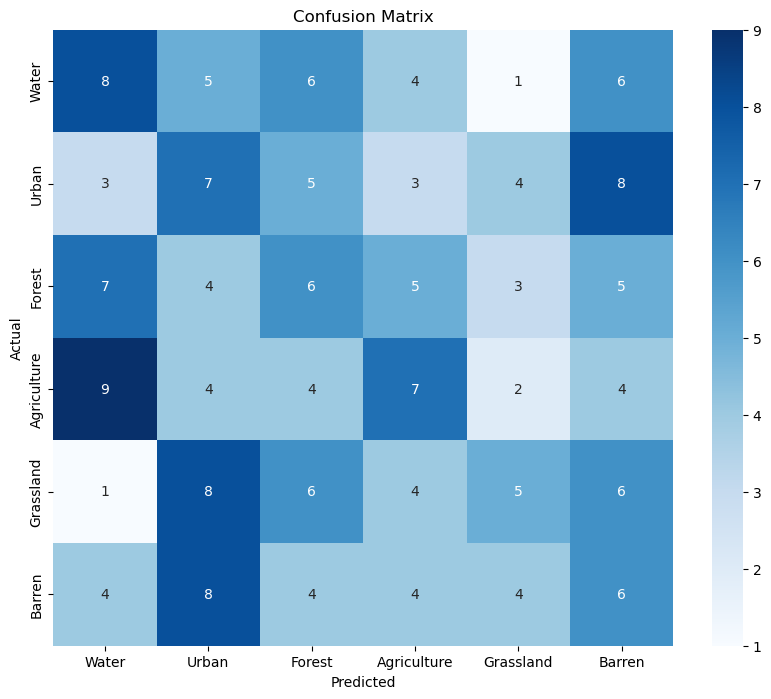

Confusion Matrix Analysis:
Water confused with Urban: 5 samples (16.7%)
Water confused with Forest: 6 samples (20.0%)
Water confused with Agriculture: 4 samples (13.3%)
Water confused with Barren: 6 samples (20.0%)
Urban confused with Forest: 5 samples (16.7%)
Urban confused with Grassland: 4 samples (13.3%)
Urban confused with Barren: 8 samples (26.7%)
Forest confused with Water: 7 samples (23.3%)
Forest confused with Urban: 4 samples (13.3%)
Forest confused with Agriculture: 5 samples (16.7%)
Forest confused with Barren: 5 samples (16.7%)
Agriculture confused with Water: 9 samples (30.0%)
Agriculture confused with Urban: 4 samples (13.3%)
Agriculture confused with Forest: 4 samples (13.3%)
Agriculture confused with Barren: 4 samples (13.3%)
Grassland confused with Urban: 8 samples (26.7%)
Grassland confused with Forest: 6 samples (20.0%)
Grassland confused with Agriculture: 4 samples (13.3%)
Grassland confused with Barren: 6 samples (20.0%)
Barren confused with Water: 4 samples (13.3

In [23]:
# Analyze confusion patterns
confusion_matrix_result = create_confusion_matrix_analysis(y_val, y_pred, LAND_COVER_CLASSES)

In [24]:
### Feature Importance Analysis

def analyze_feature_importance(model, feature_names):
    """
    Analyze and visualize feature importance

    Think about: How do you interpret feature importance scores?
    """

    # Get feature importance scores
    importance_scores = model.feature_importances_

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False)

    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)  # Show top 15

    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

    # Print top features
    print("Top 10 Most Important Features:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<12} {row['importance']:.4f}")

    return importance_df

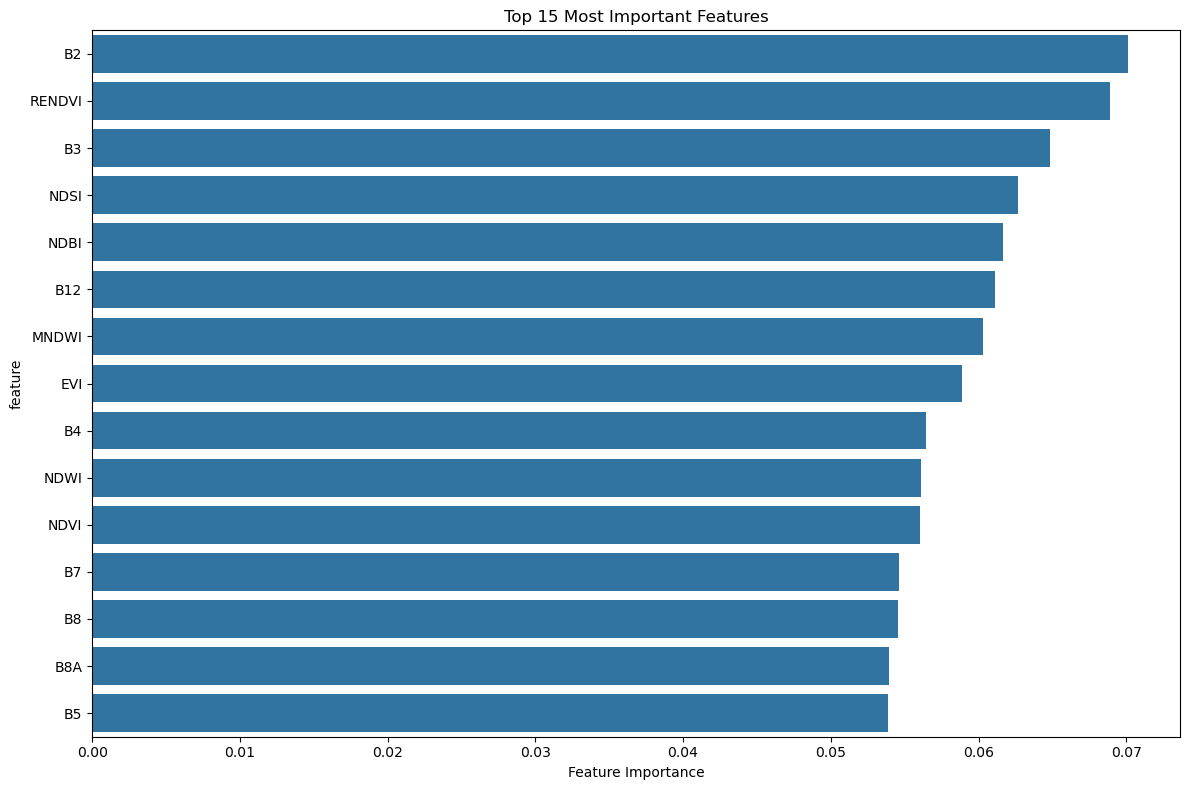

Top 10 Most Important Features:
 1. B2           0.0701
 2. RENDVI       0.0689
 3. B3           0.0648
 4. NDSI         0.0627
 5. NDBI         0.0617
 6. B12          0.0611
 7. MNDWI        0.0603
 8. EVI          0.0589
 9. B4           0.0565
10. NDWI         0.0561


In [25]:
# Analyze feature importance
feature_importance_df = analyze_feature_importance(rf_classifier, feature_columns)

In [26]:
##  Applying the Model to the Full Study Area

### Creating the Classification Map


def apply_model_to_image(trained_model, feature_names, ee_image, study_region):
    """
    Apply trained scikit-learn model to Earth Engine image

    Challenge: How do we bridge between scikit-learn and Earth Engine?
    """

    # This is a conceptual framework - in practice, you'd use Earth Engine's
    # classifier.smileRandomForest() or export data for local processing

    print("Model application strategy:")
    print("1. Export image features to local environment")
    print("2. Apply scikit-learn model")
    print("3. Create classification map")

    # For demonstration, let's sample the image at a grid of points
    # In practice, you might export the full image or use Earth Engine's classifiers

    # Create a grid of points for demonstration
    grid_points = ee.FeatureCollection.randomPoints(study_region, 1000, seed=42)

    # Sample the image at these points
    sampled_data = ee_image.sampleRegions(
        collection=grid_points,
        properties=[],
        scale=10,
        projection='EPSG:4326'
    )

    return sampled_data

In [27]:
# Apply model (demonstration approach)
classification_samples = apply_model_to_image(rf_classifier, feature_columns, training_composite, study_area)

Model application strategy:
1. Export image features to local environment
2. Apply scikit-learn model
3. Create classification map


In [ ]:
print("Classification sampling completed")
print(f"Generated {classification_samples.size().getInfo()} classification samples")

Classification sampling completed


In [ ]:
### Validation Strategy for Full Classification

def design_validation_strategy():
    """
    Design a strategy for validating the full classification

    Discuss: What makes a validation strategy robust and reliable?
    """

    validation_approaches = {
        'independent_samples': {
            'description': 'Collect new ground truth samples not used in training',
            'pros': ['Unbiased assessment', 'True performance estimate'],
            'cons': ['Requires additional fieldwork', 'Time and cost intensive'],
            'when_to_use': 'High-stakes applications, research publications'
        },

        'visual_assessment': {
            'description': 'Expert visual review of classification results',
            'pros': ['Quick implementation', 'Can identify systematic errors'],
            'cons': ['Subjective', 'Limited sample size', 'Expert bias'],
            'when_to_use': 'Rapid prototyping, internal quality checks'
        },

        'cross_validation': {
            'description': 'Use holdout portions of training data',
            'pros': ['No additional data needed', 'Statistical rigor'],
            'cons': ['May not represent full study area', 'Spatial autocorrelation issues'],
            'when_to_use': 'Development phase, parameter tuning'
        },

        'reference_datasets': {
            'description': 'Compare against existing land cover products',
            'pros': ['Readily available', 'Large area coverage'],
            'cons': ['May have different class definitions', 'Unknown accuracy'],
            'when_to_use': 'Relative comparison, consistency checking'
        }
    }

    return validation_approaches

In [ ]:
validation_strategies = design_validation_strategy()

In [ ]:
print("Validation Strategy Options:")
for strategy, details in validation_strategies.items():
    print(f"\n{strategy.upper().replace('_', ' ')}:")
    print(f"  Description: {details['description']}")
    print(f"  Best for: {details['when_to_use']}")